In [1]:
import numpy as np
import pandas as pd
import sys, os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
import scipy.optimize as optimize
from scipy.optimize import fsolve
from random import sample
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import shap
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

Data_Path = "../Data/25bp_Data/"

In [2]:
cell_type_pairs = [["T01", x] for x in ["T{0:0=2d}".format(x) for x in range(2, 3)]]
assays = ["A{0:0=2d}".format(x) for x in range(1, 2)]
Avocado_list = ["T07_A03", "T11_A04", "T12_A07", "T08_A01", "T09_A01", "T10_A01", "T11_A01", "T12_A01", "T13_A01", "T13_A03"]

linear_scaling_value_reference = 0.0
linear_scaling_value_target = 0.0

In [3]:
S3norm_parameters = {}
for assay_type in assays:
    for cell_types in cell_type_pairs:
        if(cell_types[1]+"_"+assay_type in Avocado_list):
            print("Sample from Avocado...")
#             continue        

#         f_S3norm_parameters = open("../Data/S3norm_parameters.tsv", 'a')

        common_peak_indices = {}
        common_peak_values = {}
        common_peak_values[1] = []
        common_peak_values[2] = []
        common_background_indices = {}
        common_background_values = {}
        common_background_values[1] = []
        common_background_values[2] = []
        remaining_values = {}
        remaining_values[1] = []
        remaining_values[2] = []

        for chrom in list(range(9, 10)): #  + ["X"]:

            x1 = np.load(Data_Path + cell_types[0]+assay_type+".chr"+str(chrom)+".npy")
            x2 = np.load(Data_Path + cell_types[1]+assay_type+".chr"+str(chrom)+".npy")

            x1_pvalues = np.power(10, -1.0 * x1)
            x2_pvalues = np.power(10, -1.0 * x2)

            chromosome_length = x1.shape[0]
            print("Number of 25bp bins in chr"+str(chrom)+" = "+str(chromosome_length))

            x1_FDR = sm.stats.fdrcorrection(x1_pvalues, alpha=0.05, method='indep', is_sorted=False)
            x1_peaks = [idx for idx, v in enumerate(x1_FDR[0]) if v == True]
            x1_background = [idx for idx, v in enumerate(x1_FDR[0]) if v == False]
        
            if(cell_types[1]+"_"+assay_type in Avocado_list):
                x2_peaks = np.argpartition(x2_pvalues, 10000)[:10000] # Find the smallest 1000 p-values and assign them as peaks as per Jacob's suggestion on October 11 2021
                x2_background = list( set(list(range(chromosome_length))) - set(list(x2_peaks)) ) # everything else is background
            else:
                x2_FDR = sm.stats.fdrcorrection(x2_pvalues, alpha=0.05, method='indep', is_sorted=False)
                x2_peaks = [idx for idx, v in enumerate(x2_FDR[0]) if v == True]    
                x2_background = [idx for idx, v in enumerate(x2_FDR[0]) if v == False]

            common_peaks_chrom = list(set(x1_peaks) & set(x2_peaks))
#             print("Number of common peaks for chr"+str(chrom)+" = "+str(len(common_peaks_chrom)))
            common_peak_indices[chrom] = common_peaks_chrom
            common_peak_values[1].extend(x1[common_peaks_chrom])
            common_peak_values[2].extend(x2[common_peaks_chrom])

            common_background_chrom = list(set(x1_background) & set(x2_background))
#             print("Number of common background for chr"+str(chrom)+" = "+str(len(common_background_chrom)))
            common_background_indices[chrom] = common_background_chrom
            common_background_values[1].extend(x1[common_background_chrom])
            common_background_values[2].extend(x2[common_background_chrom])

            remaining_indices = list( set(list(set(range(chromosome_length)) - set(common_peaks_chrom))) - set(common_background_chrom) )
            remaining_values[1].extend(x1[remaining_indices])
            remaining_values[2].extend(x2[remaining_indices])
            
        # Perform linear and multiplicative scaling of -log10(p-values)
        scale_reference = min(common_peak_values[1])
        common_peaks_mean_1 = np.mean([(linear_scaling_value_reference + x) / scale_reference for x in common_peak_values[1]])
        common_background_mean_1 = np.mean([np.maximum( (linear_scaling_value_reference + x) / scale_reference, 0.0) for x in common_background_values[1]])

        scale_target = min(common_peak_values[2])
        common_peaks_2 = [(linear_scaling_value_target + x) / scale_target for x in common_peak_values[2]]
        common_background_2 = sample(common_background_values[2], 100000) # sub-sample from background of target cell type        
        common_background_2 = [np.maximum( (linear_scaling_value_target + x) / scale_target, 0.0 ) for x in common_background_2]        
        
        # Now we solve the S3norm optimization problem to match the peak and background means of the second cell type to the first
        def log_linear(parameters):
            # print(parameters)  # <-- you'll see that parameters is a NumPy array
            a, b = parameters # <-- for readability you may wish to assign names to the component variables

            LHS_1 = common_peaks_mean_1
            RHS_1 = np.mean(a * np.power(common_peaks_2, b))

            LHS_2 = common_background_mean_1
            RHS_2 = np.mean(a * np.power(common_background_2, b))

            output = (np.power(LHS_1 - RHS_1, 2) + np.power(LHS_2 - RHS_2, 2))
            return output

        initial_guess = [1, 1]
        fitted_parameters = optimize.minimize(log_linear, initial_guess, method = 'Powell', options={"maxiter":100000})
        # fitted_parameters = fsolve(log_linear, initial_guess)
        alpha, beta = fitted_parameters.x
        print(cell_types[1], assay_type, alpha, beta, log_linear([alpha, beta]), file=sys.stderr)
        S3norm_parameters[(cell_types[1], assay_type)] = (alpha, beta)
#         print(cell_types[1], assay_type, alpha, beta, log_linear([alpha, beta]), file=f_S3norm_parameters)
#         f_S3norm_parameters.close()


Number of 25bp bins in chr9 = 5535789


T02 A01 0.8553923859642262 1.1928508597448906 4.333342374871281e-34


In [4]:
# np.mean(alpha * np.power(np.maximum( transformed_common_background_values, 0), beta))


# min(common_background_values[2])

# np.save("common_peaks_mean_1.npy", common_peaks_mean_1)
# np.save("common_peaks_2.npy", common_peaks_2)
# np.save("common_background_mean_1.npy", common_background_mean_1)
# np.save("common_background_2.npy", common_background_2)

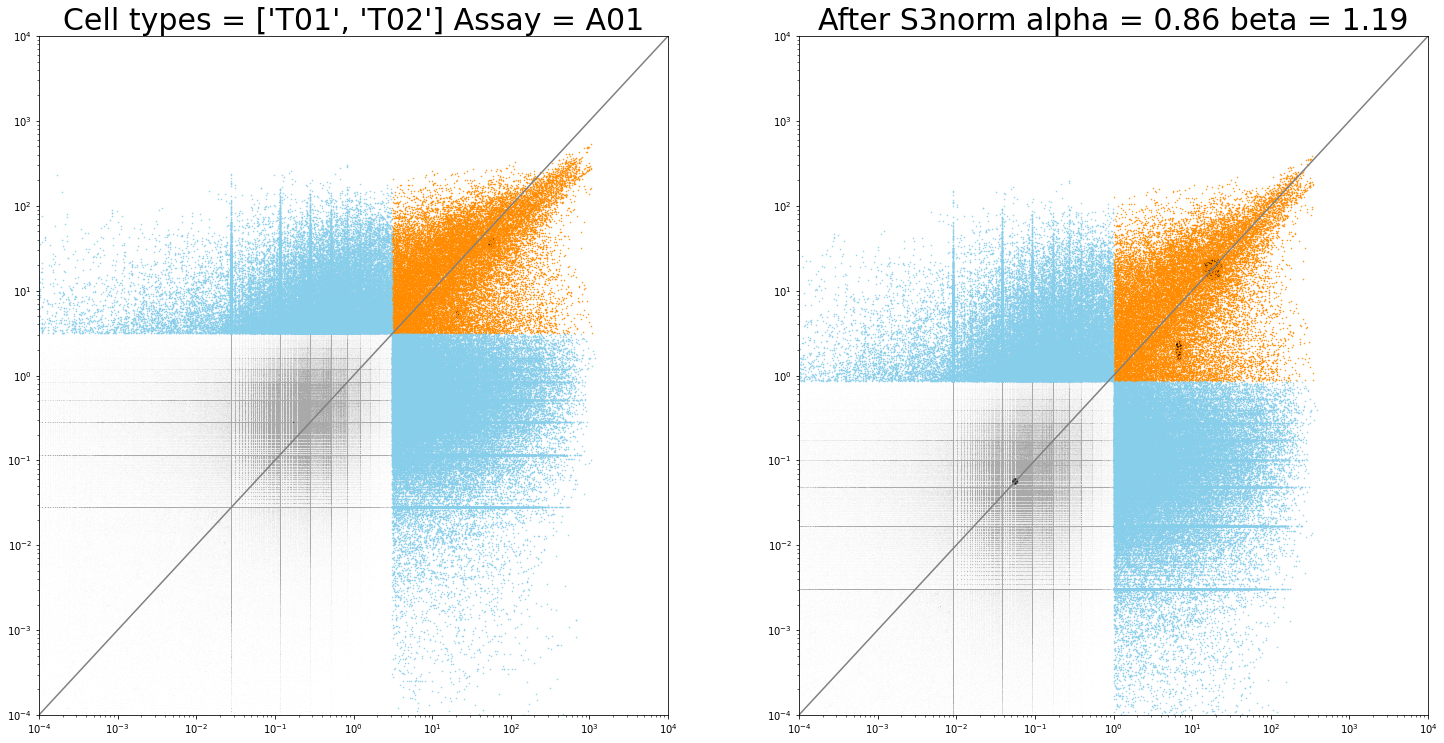

In [5]:
# Plot before and after log_linear correction 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=False)
fig.tight_layout(pad=1, w_pad=10, h_pad=15)
plt.rcParams['agg.path.chunksize'] = 1000

ax_1 = axes[0]
ax_2 = axes[1]

ax_1.plot(common_background_values[1], common_background_values[2], 'o', markersize=0.005, color="darkgrey")
ax_1.plot(common_peak_values[1], common_peak_values[2], 'o', markersize=0.5, color="darkorange")
ax_1.plot(remaining_values[1], remaining_values[2], 'o', markersize=0.5, color="skyblue")

ax_1.add_patch(plt.Circle((np.mean(common_background_values[1]), np.mean(common_background_values[2])), 0.005, color='black', linewidth=0.02, fill=True))
ax_1.add_patch(plt.Circle((np.mean(common_peak_values[1]), np.mean(common_peak_values[2])), 5, color='black', linewidth=2, fill=True))
ax_1.add_patch(plt.Circle((np.mean(remaining_values[1]), np.mean(remaining_values[2])), 0.5, color='black', linewidth=2, fill=True))

# model = linear_model.LinearRegression(normalize=False)
# model.fit(df_x1, df_x2)
# plt.plot(df_x1, model.predict(df_x1), 'o', markersize=0.007, color='k')

ax_1.set_xscale('log')
ax_1.set_yscale('log')
x_left =  0.0001
x_right = +10000
ax_1.set_xlim(x_left, x_right)
ax_1.set_ylim(x_left, x_right)

ax_1.plot([x_left, x_right], [x_left, x_right], color='grey')
ax_1.set_title("Cell types = "+str(cell_types)+" Assay = "+str(assay_type), fontsize=30)

transformed_common_background_values = np.maximum( [((linear_scaling_value_target + x) / scale_target) for x in common_background_values[2]], 0.0)
transformed_common_peak_values = np.maximum( [((linear_scaling_value_target + x) / scale_target) for x in common_peak_values[2]], 0.0)
transformed_remaining_values = np.maximum( [((linear_scaling_value_target + x) / scale_target) for x in remaining_values[2]], 0.0)

ax_2.plot([((linear_scaling_value_reference + x) / scale_reference) for x in common_background_values[1]], 
           alpha * np.power(transformed_common_background_values, beta), 'o', markersize=0.005, color="darkgrey")
ax_2.plot([((linear_scaling_value_reference + x) / scale_reference) for x in common_peak_values[1]], 
          alpha * np.power(transformed_common_peak_values, beta), 'o', markersize=0.5, color="darkorange")
ax_2.plot([((linear_scaling_value_reference + x) / scale_reference) for x in remaining_values[1]], 
          alpha * np.power(transformed_remaining_values, beta), 'o', markersize=0.5, color="skyblue")

ax_2.add_patch(plt.Circle((np.mean([((linear_scaling_value_reference + x) / scale_reference) for x in common_background_values[1]]), 
                            np.mean(alpha * np.power(transformed_common_background_values, beta))), 0.005, color='black', linewidth=0.02, fill=True))
ax_2.add_patch(plt.Circle((np.mean([((linear_scaling_value_reference + x) / scale_reference) for x in common_peak_values[1]]), 
                           np.mean(alpha * np.power(transformed_common_peak_values, beta))), 5, color='black', linewidth=2, fill=True))
ax_2.add_patch(plt.Circle((np.mean([((linear_scaling_value_reference + x) / scale_reference) for x in remaining_values[1]]), 
                           np.mean(alpha * np.power(transformed_remaining_values, beta))), 0.5, color='black', linewidth=2, fill=True))

# # model = linear_model.LinearRegression(normalize=False)
# # model.fit(df_x1, df_x2)
# # plt.plot(df_x1, model.predict(df_x1), 'o', markersize=0.007, color='k')

ax_2.set_xscale('log')
ax_2.set_yscale('log')
x_left =  0.0001
x_right = +10000
ax_2.set_xlim(x_left, x_right)
ax_2.set_ylim(x_left, x_right)

ax_2.plot([x_left, x_right], [x_left, x_right], color='grey')
ax_2.set_title("After S3norm alpha = "+str(round(alpha, 2))+" beta = "+str(round(beta, 2)), fontsize=30)

plt.show()
plt.close()

(0.0, 30.0)

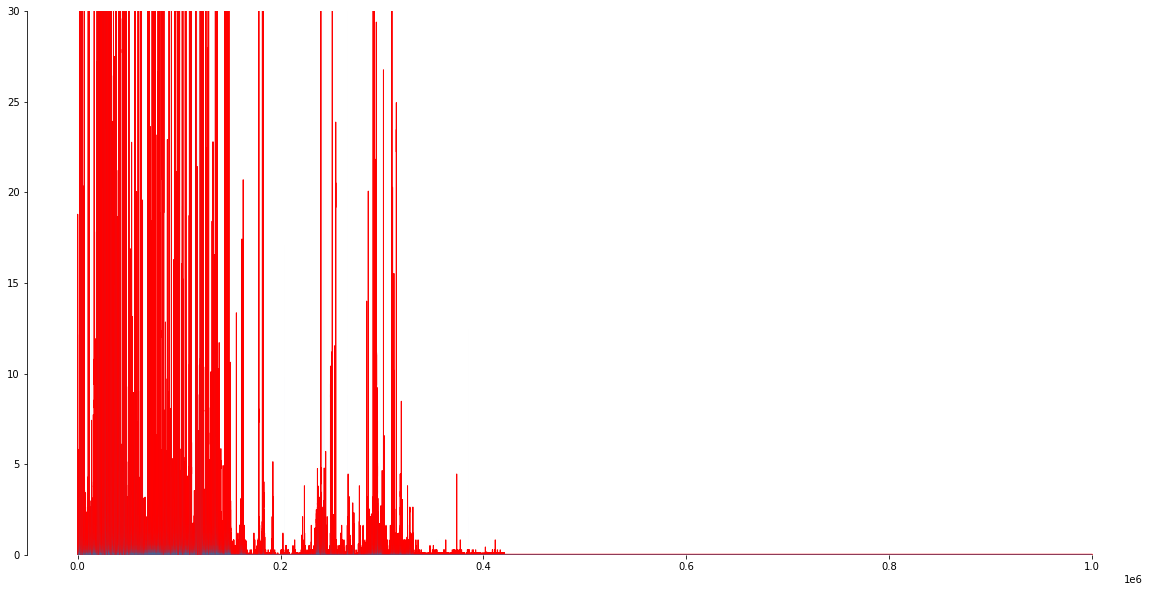

In [6]:
# Visualize two tracks in 1D
plt.rcParams["figure.figsize"] = (20, 10)
y = x2[1400000:2400000]
plt.fill_between(np.linspace(1, 1000000, num=len(y)), y, color="red")
sns.despine(top=True, right=True, bottom=True)

y = x1[1400000:2400000]
plt.fill_between(np.linspace(1, 1000000, num=len(y)), y)
sns.despine(top=True, right=True, bottom=True)

plt.ylim(0, 30)
